<a href="https://colab.research.google.com/github/FLCarvalho/TechChallenge_fase2/blob/main/TechChallenge_bovespa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Definição do tech challenge**

**Problema**: Você foi recentemente alocado em uma equipe de cientistas de dados de um grande fundo de investimentos brasileiro. Sua missão inicial é desenvolver um modelo preditivo capaz de prever se o índice IBOVESPA vai fechar em alta ou baixa no dia seguinte, com base em dados históricos do próprio índice. Esse modelo será usado como insumo para alimentar dashboards internos de tomada de decisão dos analistas quantitativos da empresa.

**Objetivo**: Criar um modelo que preveja se o fechamento do IBOVESPA do dia seguinte será maior ou menor que o do dia atual, ou seja: Seu modelo deve prever a tendência (↑ ou ↓) com acuracidade mínima de 75% em um conjunto de teste. O conjunto de testes deverá conter o último mês (30 dias) de dados disponíveis.

### **2. Importação de bibliotecas e base de dados**

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

2.1 Importação e Analise Exploratória

In [195]:
df = pd.read_csv('https://raw.githubusercontent.com/FLCarvalho/TechChallenge_fase2/refs/heads/main/Dados_Historicos_Ibovespa_2010_2025.csv')

In [196]:
df.shape

(3922, 7)

In [197]:
df.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,23.10.2025,145.721,144.881,146.358,144.881,"6,60M","0,59%"
1,22.10.2025,144.873,144.094,145.048,144.039,"7,02B","0,55%"
2,21.10.2025,144.085,144.509,144.795,143.829,"6,19B","-0,29%"
3,20.10.2025,144.509,143.399,145.216,143.396,"6,79B","0,77%"
4,17.10.2025,143.399,142.200,143.424,141.248,"8,88B","0,84%"


Informações da base de dados:

* Data - Data da negociação.
* Último - Fechamento do índice no dia (em pontos).
* Abertura - Valor do índice na abertura do pregão (em pontos).
* Máxima - Maior valor do índice durante o dia (em pontos).
* Mínima- Menor valor do índice durante o dia (em pontos).
* Vol. - Volume de negociações (quantidade de ações ponderadas, em geral).
* Var% - Variação percentual do índice em relação ao fechamento do dia anterior.

In [198]:
# Como as colunas 'vol.' e 'Var%' estão como object contendo letras e simbolos foi tomada a decisão de retirar essas colunas e caso necessário calcular a variação futuramente.
df = df.drop(columns=['Vol.', 'Var%'])

In [199]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3922 entries, 0 to 3921
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      3922 non-null   object 
 1   Último    3922 non-null   float64
 2   Abertura  3922 non-null   float64
 3   Máxima    3922 non-null   float64
 4   Mínima    3922 non-null   float64
dtypes: float64(4), object(1)
memory usage: 153.3+ KB


2.2 Pré-processamento temporal

In [200]:
df['Data'] = pd.to_datetime(df['Data'])  #Garantindo que a informação está no formato de data
df = df.set_index('Data')     # Definindo data como o indice

/tmp/ipython-input-3756142610.py:1: UserWarning: Parsing dates in %d.%m.%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Data'] = pd.to_datetime(df['Data'])  #Garantindo que a informação está no formato de data


In [201]:
df.head()

,Último,Abertura,Máxima,Mínima
Data,,,,
2025-10-23,145.721,144.881,146.358,144.881
2025-10-22,144.873,144.094,145.048,144.039
2025-10-21,144.085,144.509,144.795,143.829
2025-10-20,144.509,143.399,145.216,143.396
2025-10-17,143.399,142.200,143.424,141.248


In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3922 entries, 2025-10-23 to 2010-01-04
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    3922 non-null   float64
 1   Abertura  3922 non-null   float64
 2   Máxima    3922 non-null   float64
 3   Mínima    3922 non-null   float64
dtypes: float64(4)
memory usage: 153.2 KB


In [203]:
df = df.sort_index()   # Arrumando os dados em ordem cronologica e fazendo a checagem

if df.index.is_monotonic_increasing:
    print("Os dados estão em ordem cronológica.")
else:
    print("Os dados não estão em ordem cronológica.")


Os dados estão em ordem cronológica.


### **3. Análise Exploratória dos Dados Temporais**

3.1 Visualização dos dados

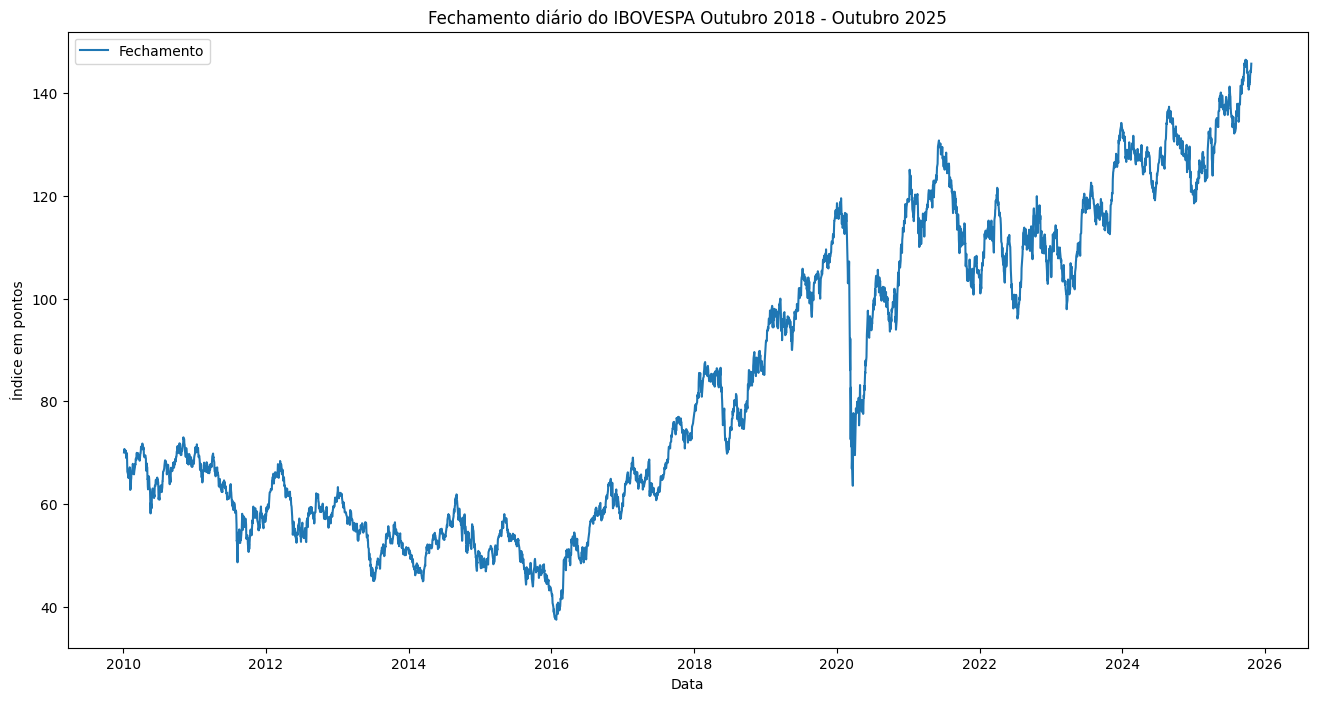

In [204]:
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['Último'], label='Fechamento')
plt.title('Fechamento diário do IBOVESPA Outubro 2018 - Outubro 2025')
plt.xlabel('Data')
plt.ylabel('Índice em pontos')
plt.legend()
plt.show()

3.2 Decomposição da Série Temporal

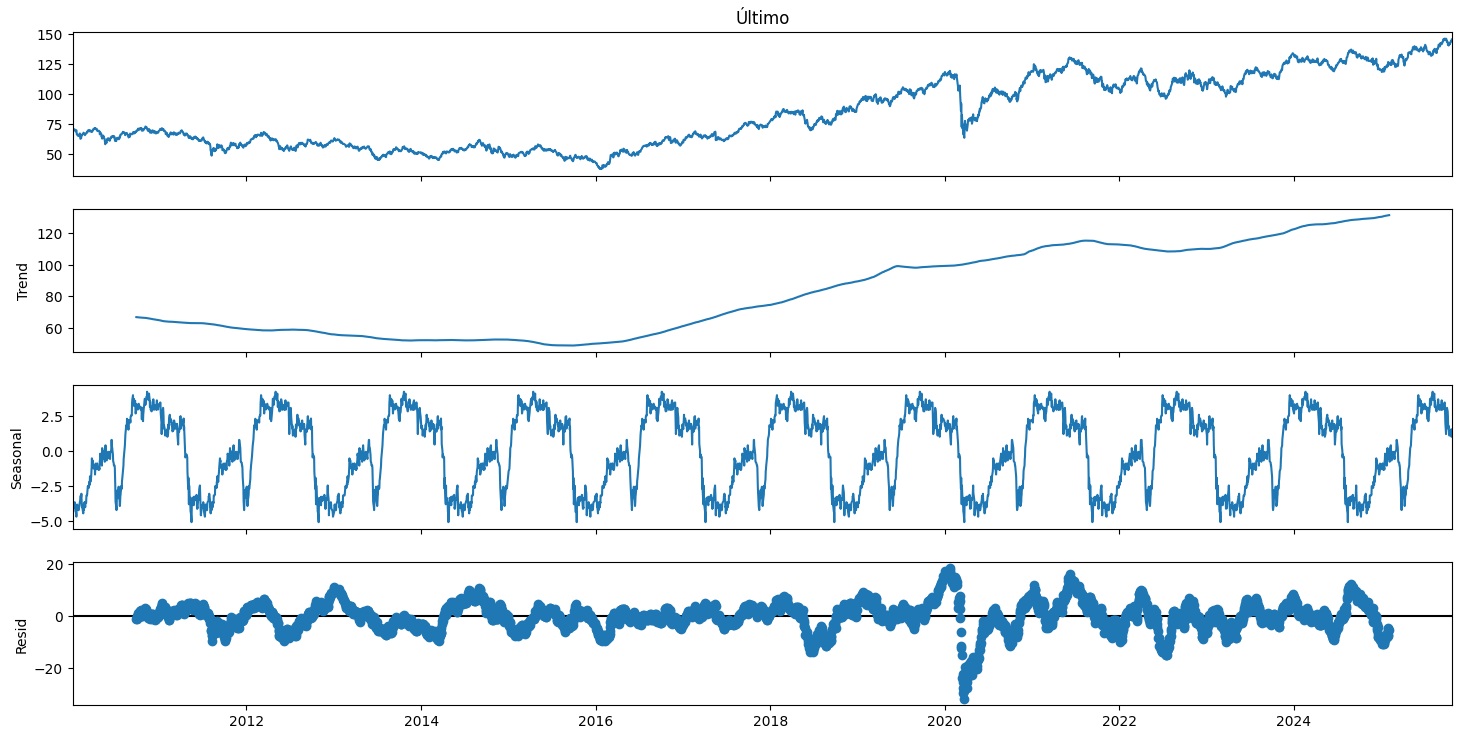

In [205]:
resultado = seasonal_decompose(df['Último'], period=365)

ax = resultado.plot()
ax.get_figure().set_size_inches(16, 8)
plt.show()

### **4. Teste de Estacionariedade**

4.1 Teste de Dickey-Fuller Aumentado (ADF)

In [206]:
from statsmodels.tsa.stattools import adfuller

# Teste ADF
resultado = adfuller(df['Último'])
print('Estatística ADF:', resultado[0])
print('p-valor:', resultado[1])
print('Nº de lags usados:', resultado[2])
print('Nº de observações:', resultado[3])
for key, value in resultado[4].items():
    print(f'Valor crítico ({key}): {value:.4f}')

# Interpretação
if resultado[1] < 0.05:
    print("A série é estacionária.")
else:
    print("A série NÃO é estacionária.")

Estatística ADF: -0.46816364956359124
p-valor: 0.8980808518680559
Nº de lags usados: 8
Nº de observações: 3913
Valor crítico (1%): -3.4320
Valor crítico (5%): -2.8623
Valor crítico (10%): -2.5672
A série NÃO é estacionária.


### 5. Estacionarização da Série Temporal

5.1 Diferenciação de Primeira Ordem

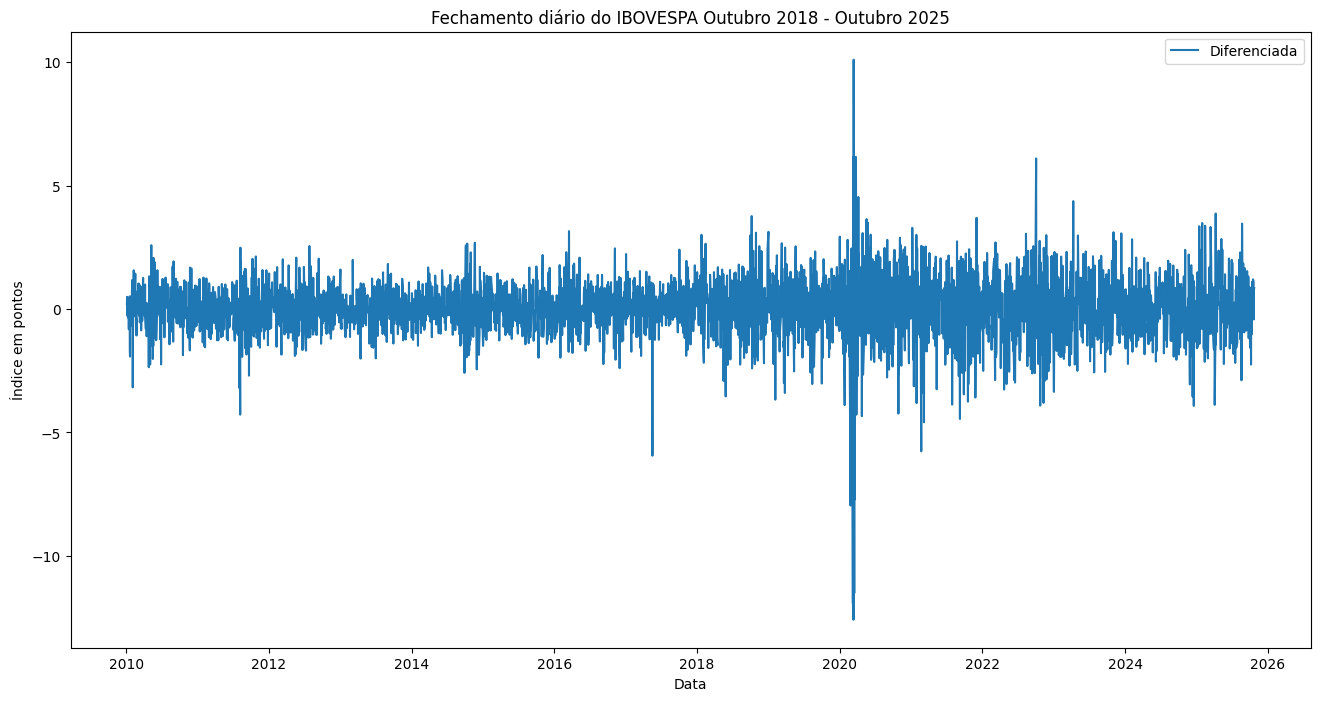

In [207]:
# Diferenciação de primeira ordem
df['diff1'] = df['Último'] - df['Último'].shift(1)
df = df.dropna(subset=['diff1'])

# Plot da sérei diferenciada
plt.figure(figsize=(16, 8))
plt.plot(df.index, df['diff1'], label='Diferenciada')
plt.title('Fechamento diário do IBOVESPA Outubro 2018 - Outubro 2025')
plt.xlabel('Data')
plt.ylabel('Índice em pontos')
plt.legend()
plt.show()


In [208]:
df.head()

,Último,Abertura,Máxima,Mínima,diff1
Data,,,,,
2010-01-05,70.240,70.046,70.595,69.928,0.195
2010-01-06,70.729,70.236,70.937,70.016,0.489
2010-01-07,70.451,70.723,70.723,70.045,-0.278
2010-01-08,70.263,70.455,70.766,70.158,-0.188
2010-01-11,70.433,70.267,71.068,70.158,0.170


In [209]:
# Teste ADF
resultado_diff = adfuller(df['diff1'].dropna()) # Added dropna() here
print('Estatística ADF:', resultado_diff[0]) # Corrected variable name
print('p-valor:', resultado_diff[1]) # Corrected variable name
print('Nº de lags usados:', resultado_diff[2]) # Added for completeness
print('Nº de observações:', resultado_diff[3]) # Added for completeness
for key, value in resultado_diff[4].items(): # Added for completeness
    print(f'Valor crítico ({key}): {value:.4f}') # Added for completeness


# Interpretação
if resultado_diff[1] < 0.05: # Corrected variable name
    print("A série é estacionária.")
else:
    print("A série NÃO é estacionária.")

Estatística ADF: -20.694654672799064
p-valor: 0.0
Nº de lags usados: 7
Nº de observações: 3913
Valor crítico (1%): -3.4320
Valor crítico (5%): -2.8623
Valor crítico (10%): -2.5672
A série é estacionária.
